In [1]:
import numpy as np
import pandas as pd
import numpy.random as npr
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal
import torch
from PIL import Image
from torchvision.transforms import ToTensor
import os
import h5py

In [38]:
from ret_analysis_functions import * #imports utilities.py file which has functions for plotting psychometrics and other useful things


In [78]:
path = "/Volumes/Runyan2/Akhil/Sensory Mapping + Retinotopy_AKHIL/HR-18-1L/MappingParadigm/28-Nov-2023/"
align_file_name = 'HR-18-1L_blue_2023-11-28_000'
file_num = 1

In [85]:
paths_azimuth_LR = []
for file_num in [1,2,3,4]: 
    path_azimuth_LR = path + 'L2R/' + 'Frames_1_640_540_uint16_000{}.dat'.format(file_num)
    paths_azimuth_LR.append(path_azimuth_LR)
paths_azimuth_RL = []
for file_num in [5,6,7,8]: 
    path_azimuth_RL = path + 'R2L/' + 'Frames_1_640_540_uint16_000{}.dat'.format(file_num)
    paths_azimuth_RL.append(path_azimuth_RL)
paths_azimuth_BU = []
for file_num in [9,10,11,12]: 
    if file_num == 9:
        path_azimuth_BU = path + 'B2U/' + 'Frames_1_640_540_uint16_000{}.dat'.format(file_num)
    elif file_num > 9:
        path_azimuth_BU = path + 'B2U/' + 'Frames_1_640_540_uint16_00{}.dat'.format(file_num)
    paths_azimuth_BU.append(path_azimuth_BU)
paths_azimuth_UB = []
for file_num in [13,14,15,16]: 
    path_azimuth_UB = path + 'U2B/' + 'Frames_1_640_540_uint16_00{}.dat'.format(file_num)
    paths_azimuth_UB.append(path_azimuth_UB)


In [91]:
paths_azimuth_LR[0]

'/Volumes/Runyan2/Akhil/Sensory Mapping + Retinotopy_AKHIL/HR-18-1L/MappingParadigm/28-Nov-2023/L2R/Frames_1_640_540_uint16_0001.dat'

In [86]:
def get_stim_times(path, direction, align_file_name, file_num):
        # Load the uploaded .hf file
        if file_num < 10:
            file_path = path + direction + align_file_name + '{}.h5'.format(file_num)
        elif file_num > 9:
            file_path = path + direction + align_file_name[:-1] + '{}.h5'.format(file_num)
        # Open the file
        with h5py.File(file_path, 'r') as file:
            # List all groups
            print("Keys: %s" % file.keys())
            keys_list = list(file.keys())
            key = keys_list[1]
            stimulus = file[key]['analogScans'][()][0]/30000
            imaging = file[key]['digitalScans'][()][0]
            time_imaged = np.where(imaging > 0)[0]
            time_stimulus = np.where(stimulus > 0)[0]
            length_of_imaging = time_imaged[-1] - time_imaged[0]
            conv = 320000/905
            start_of_stim = (time_stimulus[0]-time_imaged[0])/conv
            if file_num < 9:
                end_of_stim = start_of_stim + 20*30
            elif file_num > 8:
                end_of_stim = start_of_stim + 18*30 

        return int(start_of_stim), int(end_of_stim)

def extract_aligned_tensor(path, direction, align_file_name, tensor, file_num):
    start, stop = get_stim_times(path, direction, align_file_name, file_num)
    return tensor[start:stop, :, :]

In [87]:
def get_mean_corrected_tensor(path, path_direction, direction, align_file_name):
    tensors_all_trials = []
    for paths in path_direction:
        tensor_single_trial = retinotopy_analysis.create_tensor_from_dat(paths)
        corrected_tensor_single_trial = retinotopy_analysis.create_stimulus_corrected_movie_pt(tensor_single_trial, 0, 60)
        direction = direction
        file_num = int(paths[-7:-4])
        tensor_aligned = extract_aligned_tensor(path, direction, align_file_name, corrected_tensor_single_trial, file_num)
        tensors_all_trials.append(tensor_aligned)
    mean_tensor = torch.mean(torch.stack(tensors_all_trials), dim=0)
    return mean_tensor

tensor_azimuthLR_mean = get_mean_corrected_tensor(path, paths_azimuth_LR, '/L2R/', align_file_name)
tensor_azimuthRL_mean = get_mean_corrected_tensor(path, paths_azimuth_RL, '/R2L/', align_file_name)
tensor_azimuthBU_mean = get_mean_corrected_tensor(path, paths_azimuth_BU, '/B2U/', align_file_name)
tensor_azimuthUB_mean = get_mean_corrected_tensor(path, paths_azimuth_UB, '/U2B/', align_file_name)

Keys: <KeysViewHDF5 ['header', 'sweep_0001']>
Keys: <KeysViewHDF5 ['header', 'sweep_0002']>
Keys: <KeysViewHDF5 ['header', 'sweep_0003']>
Keys: <KeysViewHDF5 ['header', 'sweep_0004']>
Keys: <KeysViewHDF5 ['header', 'sweep_0005']>
Keys: <KeysViewHDF5 ['header', 'sweep_0006']>
Keys: <KeysViewHDF5 ['header', 'sweep_0007']>
Keys: <KeysViewHDF5 ['header', 'sweep_0008']>
Keys: <KeysViewHDF5 ['header', 'sweep_0009']>
Keys: <KeysViewHDF5 ['header', 'sweep_0010']>
Keys: <KeysViewHDF5 ['header', 'sweep_0011']>
Keys: <KeysViewHDF5 ['header', 'sweep_0012']>
Keys: <KeysViewHDF5 ['header', 'sweep_0013']>
Keys: <KeysViewHDF5 ['header', 'sweep_0014']>
Keys: <KeysViewHDF5 ['header', 'sweep_0015']>
Keys: <KeysViewHDF5 ['header', 'sweep_0016']>


In [107]:
def phase_power_calc(movie):
    spectrumMovie = np.fft.fft(movie, axis=0)

    #generate power movie
    powerMovie = (np.abs(spectrumMovie) * 2.) / np.size(movie, 0)
    powerMap = np.abs(powerMovie[1,:,:])

    #generate phase movie
    phaseMovie = np.angle(spectrumMovie)
    phaseMap = -1 * phaseMovie[1,:,:]
    phaseMap = phaseMap % (2 * np.pi)
    return powerMap, phaseMap

az_powerMap1, az_phaseMap1 = phase_power_calc(tensor_azimuthLR_mean)
az_powerMap2, az_phaseMap2 = phase_power_calc(tensor_azimuthRL_mean)

el_powerMap1, el_phaseMap1 = phase_power_calc(tensor_azimuthBU_mean)
el_powerMap2, el_phaseMap2 = phase_power_calc(tensor_azimuthUB_mean)

el_phaseMap = (el_phaseMap1 - el_phaseMap2)
az_phaseMap = (az_phaseMap1 - az_phaseMap2)

In [114]:
visual_field_map = retinotopy_analysis.visualSignMap(az_phaseMap, el_phaseMap)

(-0.5, 299.5, 299.5, -0.5)

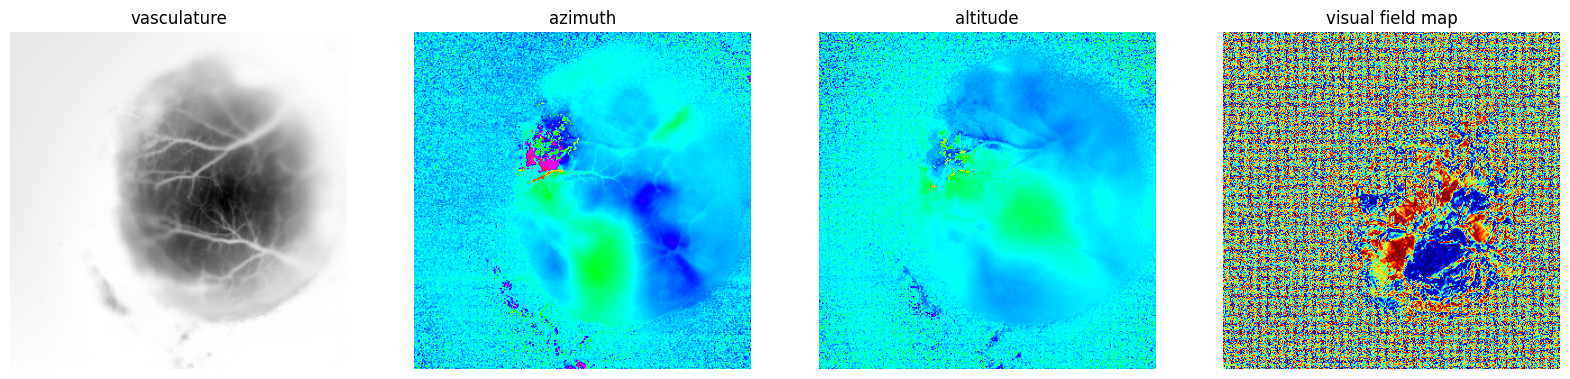

In [120]:
from scipy.ndimage import gaussian_filter

def rotation(image):
    rotated_image = np.rot90(image)
    flipped_image = np.flipud(rotated_image)
    return flipped_image

tensor_vasculature = retinotopy_analysis.create_tensor_from_dat(paths_azimuth_LR[0])

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
std_dev_range=(8, 10)
mean_std_dev = np.mean(std_dev_range)

axs[0].imshow(rotation(tensor_vasculature.mean(axis=0)), cmap="binary")
axs[0].set_title("vasculature")
axs[0].axis('off')

axs[1].imshow(rotation(az_phaseMap), cmap='hsv')
axs[1].set_title("azimuth")
axs[1].axis('off')

axs[2].imshow(rotation(el_phaseMap), cmap='hsv')
axs[2].set_title("altitude")
axs[2].axis('off')

axs[3].imshow(rotation(visual_field_map), cmap='jet')
axs[3].set_title("visual field map")
axs[3].axis('off')

(-0.5, 299.5, 299.5, -0.5)

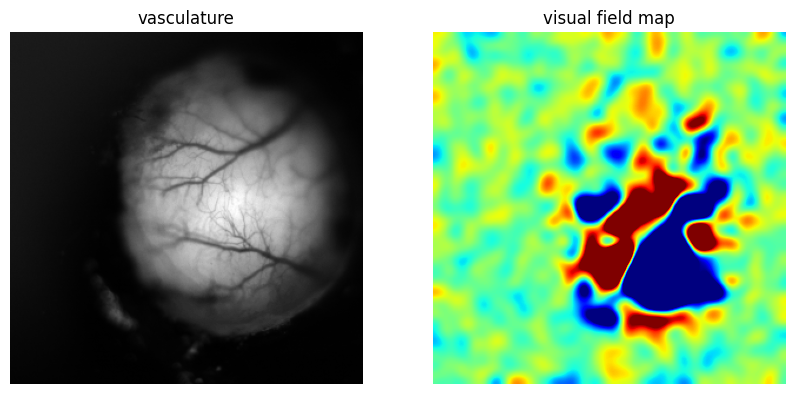

In [131]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
std_dev_range=(8, 10)
mean_std_dev = np.mean(std_dev_range)

axs[0].imshow(rotation(tensor_vasculature[0]), cmap='gray')
axs[0].set_title("vasculature")
axs[0].axis('off')

axs[1].imshow(rotation(gaussian_filter(visual_field_map, sigma=6)), cmap='jet', clim=[-0.15,0.15])
axs[1].set_title("visual field map")
axs[1].axis('off')

(-0.5, 299.5, 299.5, -0.5)

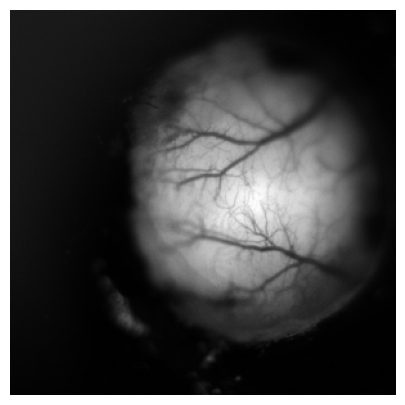

In [132]:
fig, axs = plt.subplots(figsize=(10, 5))
std_dev_range=(8, 10)
mean_std_dev = np.mean(std_dev_range)

axs.imshow(rotation(tensor_vasculature[0]), cmap='gray')
axs.axis('off')

(-0.5, 299.5, 299.5, -0.5)

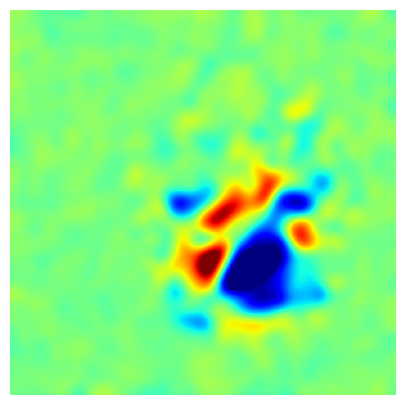

In [138]:
fig, axs = plt.subplots(figsize=(10, 5))
std_dev_range=(8, 10)
mean_std_dev = np.mean(std_dev_range)

axs.imshow(rotation(gaussian_filter(visual_field_map, sigma=6)), cmap='jet', clim=[-0.6,0.6])
axs.axis('off')